# Wavelet Learned Lossy Compression

- [Project page and documentation](https://danjacobellis.net/walloc)
- [Paper: "Learned Compression for Compressed Learning"](https://danjacobellis.net/_static/walloc.pdf)
- [Additional code accompanying the paper](https://github.com/danjacobellis/lccl)

WaLLoC (Wavelet-Domain Learned Lossy Compression) is an architecture for learned compression that simultaneously satisfies three key
requirements of compressed-domain learning:

1. **Computationally efficient encoding** to reduce overhead in compressed-domain learning and support resource constrained mobile and remote sensors. WaLLoC uses a wavelet packet transform to expose signal redundancies prior to autoencoding. This allows us to replace the encoding DNN with a single linear layer (<100k parameters) without significant loss in quality. WaLLoC incurs <5% of the encoding cost compared to other neural codecs.

2. **High compression ratio** for storage and transmission efficiency. Lossy codecs typically achieve high compression with a combination of quantization and entropy coding. However, naive quantization of autoencoder latents leads to unpredictable and unbounded distortion. Instead, we apply additive noise during training as an
entropy bottleneck, leading to quantization-resiliant latents. When combined with entropy coding, this provides nearly 12× higher compression ratio compared to the VAE used in Stable Diffusion 3, despite offering a higher degree of dimensionality reduction and similar quality.

3. **Dimensionality reduction** to accelerate compressed-domain modeling. WaLLoC’s encoder projects high-dimensional signal patches to low-dimensional latent representations, providing a reduction of up to 20×. This allows WaLLoC to be used as a drop-in replacement for resolution reduction while providing superior detail preservation and downstream accuracy.

WaLLoC does not require perceptual or adversarial losses to represent high-frequency detail, making it compatible with a wide variety of signal types. It currently supports 1D and 2D signals, including mono, stereo, and multi-channel audio and grayscale, RGB, and hyperspectral images.

![](https://danjacobellis.net/walloc/_images/walloc.svg)
WaLLoC’s encode-decode pipeline. The entropy bottleneck and entropy coding steps are only required to achieve high compression ratios for storage and transmission. For compressed-domain learning where dimensionality reduction is the primary goal, these steps can be skipped to reduce overhead and completely eliminate CPU-GPU transfers.



![](https://danjacobellis.net/walloc/_images/radar.svg)
Comparison of WaLLoC with other autoencoder designs for RGB Images and stereo audio.



![](https://danjacobellis.net/walloc/_images/walloc_4x.svg)

![](https://danjacobellis.net/walloc/_images/sd3.svg)

![](https://danjacobellis.net/walloc/_images/walloc_16x.svg)

![](https://danjacobellis.net/walloc/_images/audio_comparison.svg)

```
@article{jacobellis2024learned,
  title={Learned Compression for Compressed Learning},
  author={Jacobellis, Dan and Yadwadkar, Neeraja J.},
  year={2024},
  note={Under review},
  url={http://danjacobellis.net/walloc}
}
```

## Installation

1. Follow the installation instructions for [torch](https://pytorch.org/get-started/locally/)
2. Install WaLLoC and other dependencies via pip

```pip install walloc PyWavelets pytorch-wavelets```

## Image compression

In [1]:
import os
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
from PIL import Image, ImageEnhance
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc import walloc
from walloc.walloc import latent_to_pil, pil_to_latent

### Load the model from a pre-trained checkpoint

```wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_16x.pth```

```wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_16x.json```

In [2]:
device = "cpu"
codec_config = SimpleNamespace(**json.load(open("RGB_16x.json")))
checkpoint = torch.load("RGB_16x.pth",map_location="cpu",weights_only=False)
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

### Load an example image

```wget "https://r0k.us/graphics/kodak/kodak/kodim05.png"```

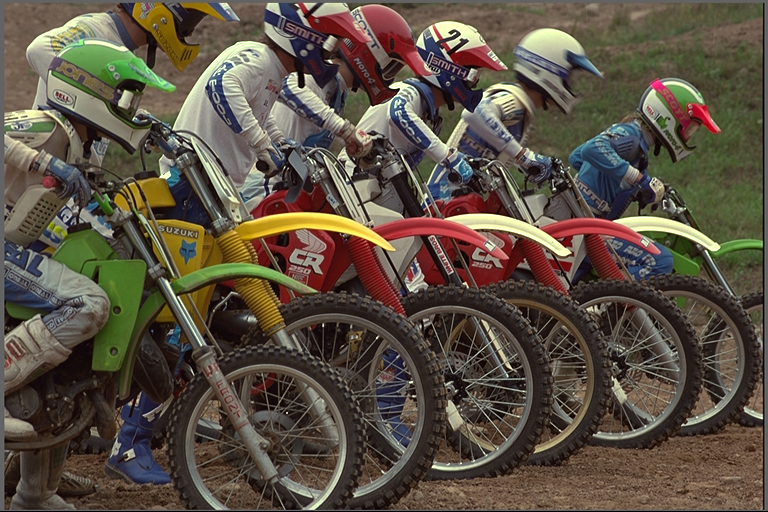

In [3]:
img = Image.open("kodim05.png")
img

### Full encoding and decoding pipeline with .forward()

* If `codec.eval()` is called, the latent is rounded to nearest integer.

* If `codec.train()` is called, uniform noise is added instead of rounding.

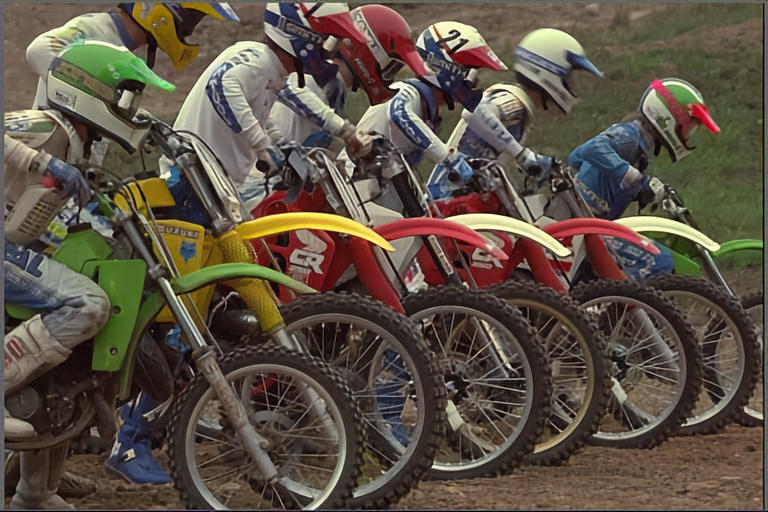

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

### Accessing latents

In [5]:
with torch.no_grad():
    X = codec.wavelet_analysis(x,J=codec.J)
    z = codec.encoder[0:2](X)
    z_hat = codec.encoder[2](z)
    X_hat = codec.decoder(z_hat)
    x_rec = codec.wavelet_synthesis(X_hat,J=codec.J)
print(f"dimensionality reduction: {x.numel()/z.numel()}×")

dimensionality reduction: 16.0×


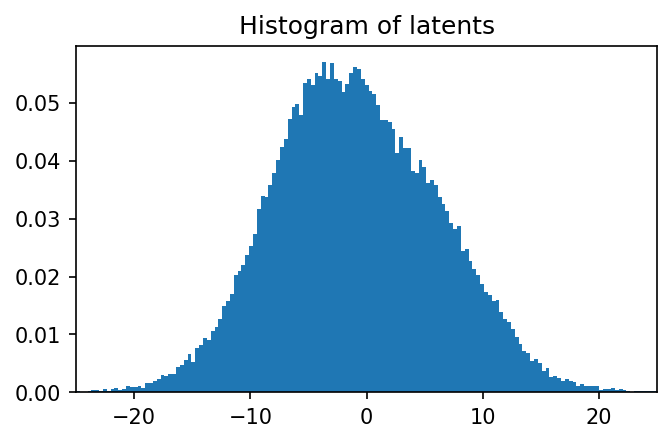

In [6]:
plt.figure(figsize=(5,3),dpi=150)
plt.hist(
    z.flatten().numpy(),
    range=(-25,25),
    bins=151,
    density=True,
);
plt.title("Histogram of latents")
plt.xlim([-25,25]);

# Lossless compression of latents

In [7]:
def scale_for_display(img, n_bits):
    scale_factor = (2**8 - 1) / (2**n_bits - 1)
    lut = [int(i * scale_factor) for i in range(2**n_bits)]
    channels = img.split()
    scaled_channels = [ch.point(lut * 2**(8-n_bits)) for ch in channels]
    return Image.merge(img.mode, scaled_channels)

### Single channel PNG (L)

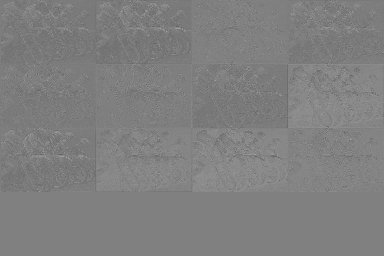

compression_ratio:  26.729991842653856


In [8]:
z_padded = torch.nn.functional.pad(z_hat, (0, 0, 0, 0, 0, 4))
z_pil = latent_to_pil(z_padded,codec.latent_bits,1)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.png')
png = [Image.open("latent.png")]
z_rec = pil_to_latent(png,16,codec.latent_bits,1)
assert(z_rec.equal(z_padded))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.png"))

### Three channel WebP (RGB)

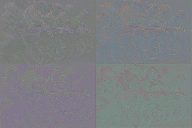

compression_ratio:  28.811254396248536


In [9]:
z_pil = latent_to_pil(z_hat,codec.latent_bits,3)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.webp',lossless=True)
webp = [Image.open("latent.webp")]
z_rec = pil_to_latent(webp,12,codec.latent_bits,3)
assert(z_rec.equal(z_hat))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.webp"))

### Four channel TIF (CMYK)

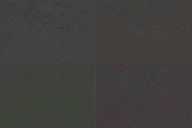

compression_ratio:  21.04034530731638


In [10]:
z_padded = torch.nn.functional.pad(z_hat, (0, 0, 0, 0, 0, 4))
z_pil = latent_to_pil(z_padded,codec.latent_bits,4)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.tif',compression="tiff_adobe_deflate")
tif = [Image.open("latent.tif")]
z_rec = pil_to_latent(tif,16,codec.latent_bits,4)
assert(z_rec.equal(z_padded))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.tif"))

# Audio Compression

In [1]:
import io
import os
import torch
import torchaudio
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace
from PIL import Image
from datasets import load_dataset
from einops import rearrange
from IPython.display import Audio
from walloc import walloc

### Load the model from a pre-trained checkpoint

```wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_5x.pth```

```wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_5x.json```

In [2]:
codec_config = SimpleNamespace(**json.load(open("stereo_5x.json")))
checkpoint = torch.load("stereo_5x.pth",map_location="cpu",weights_only=False)
codec = walloc.Codec1D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode,
    post_filter = codec_config.post_filter
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec.eval();

/home/dan/g/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


### Load example audio track

In [3]:
MUSDB = load_dataset("danjacobellis/musdb_segments_val",split='validation')
audio_buff = io.BytesIO(MUSDB[40]['audio_mix']['bytes'])
x, fs = torchaudio.load(audio_buff,normalize=False)
x = x.to(torch.float)
x = x - x.mean()
max_abs = x.abs().max()
x = x / (max_abs + 1e-8)
x = x/2

In [ ]:
Audio(x[:,:2**20],rate=44100)

<audio controls>
  <source src="README_files/README_0.wav" type="audio/wav">
</audio>

### Full encoding and decoding pipeline with .forward()

* If `codec.eval()` is called, the latent is rounded to nearest integer.

* If `codec.train()` is called, uniform noise is added instead of rounding.

In [4]:
with torch.no_grad():
    codec.eval()
    x_hat, _, _ = codec(x.unsqueeze(0))

In [ ]:
Audio(x_hat[0,:,:2**20],rate=44100)

<audio controls>
  <source src="README_files/README_1.wav" type="audio/wav">
</audio>

### Accessing latents

In [5]:
with torch.no_grad():
    X = codec.wavelet_analysis(x.unsqueeze(0),J=codec.J)
    z = codec.encoder[0:2](X)
    z_hat = codec.encoder[2](z)
    X_hat = codec.decoder(z_hat)
    x_rec = codec.wavelet_synthesis(X_hat,J=codec.J)
print(f"dimensionality reduction: {x.numel()/z.numel():.4g}×")

dimensionality reduction: 4.74×


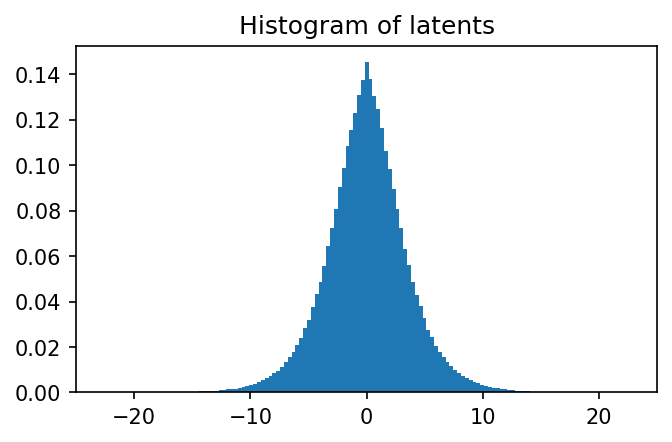

In [6]:
plt.figure(figsize=(5,3),dpi=150)
plt.hist(
    z.flatten().numpy(),
    range=(-25,25),
    bins=151,
    density=True,
);
plt.title("Histogram of latents")
plt.xlim([-25,25]);

# Lossless compression of latents

In [7]:
def pad(audio, p=2**16):
    B,C,L = audio.shape
    padding_size = (p - (L % p)) % p
    if padding_size > 0:
        audio = torch.nn.functional.pad(audio, (0, padding_size), mode='constant', value=0)
    return audio
with torch.no_grad():
    L = x.shape[-1]
    x_padded = pad(x.unsqueeze(0), 2**16)
    X = codec.wavelet_analysis(x_padded,codec.J)
    z = codec.encoder(X)
    ℓ = z.shape[-1]
    z = pad(z,128)
    z = rearrange(z, 'b c (w h) -> b c w h', h=128).to("cpu")
    webp = walloc.latent_to_pil(z,codec.latent_bits,3)[0]
    buff = io.BytesIO()
    webp.save(buff, format='WEBP', lossless=True)
    webp_bytes = buff.getbuffer()

compression_ratio:  9.83650170496386


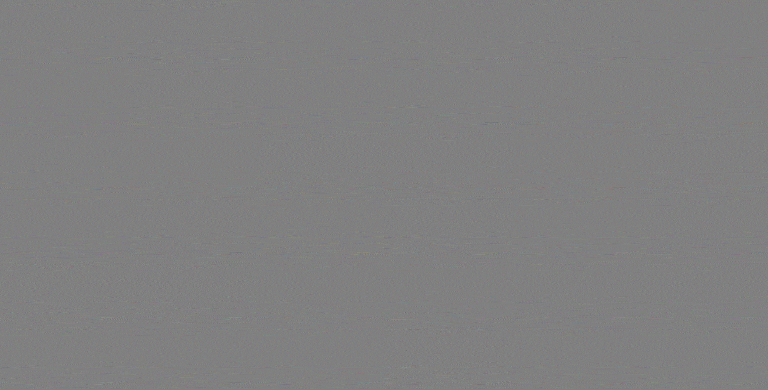

In [8]:
print("compression_ratio: ", x.numel()/len(webp_bytes))
webp

# Decoding

In [9]:
with torch.no_grad():
    z_hat = walloc.pil_to_latent(
        [Image.open(buff)],
        codec.latent_dim,
        codec.latent_bits,
        3)
    X_hat = codec.decoder(rearrange(z_hat, 'b c h w -> b c (h w)')[:,:,:ℓ])
    x_hat = codec.wavelet_synthesis(X_hat,codec.J)
    x_hat = codec.post(x_hat)
    x_hat = codec.clamp(x_hat[0,:,:L])

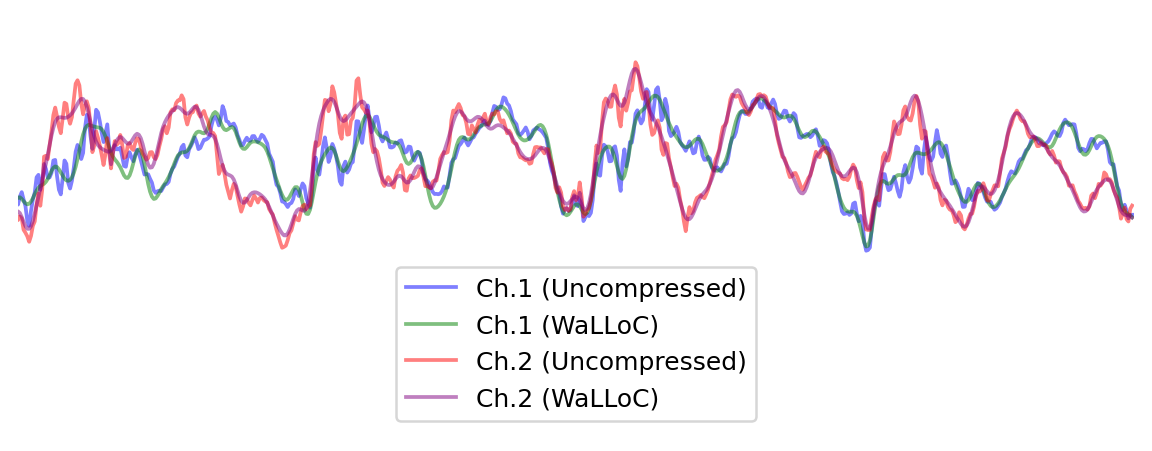

In [10]:
start, end = 0, 1000
plt.figure(figsize=(8, 3), dpi=180)
plt.plot(x[0, start:end], alpha=0.5, c='b', label='Ch.1 (Uncompressed)')
plt.plot(x_hat[0, start:end], alpha=0.5, c='g', label='Ch.1 (WaLLoC)')
plt.plot(x[1, start:end], alpha=0.5, c='r', label='Ch.2 (Uncompressed)')
plt.plot(x_hat[1, start:end], alpha=0.5, c='purple', label='Ch.2 (WaLLoC)')

plt.xlim([400,1000])
plt.ylim([-0.6,0.3])
plt.legend(loc='lower center')
plt.box(False)
plt.xticks([])
plt.yticks([]);

In [1]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Writing 12900 bytes to README.md


In [2]:
!sed -i 's|!\[png](README_files/\(README_[0-9]*_[0-9]*\.png\))|![png](https://huggingface.co/danjacobellis/walloc/resolve/main/README_files/\1)|g' README.md

In [3]:
!sed -i 's|src="README_files/\(README_[0-9]*\.wav\)"|src="https://huggingface.co/danjacobellis/walloc/resolve/main/README_files/\1"|g' README.md